# License Plate Detection

## Downloading the dataset

In [5]:
from datasets import load_dataset
ds = load_dataset("keremberke/license-plate-object-detection", name="full")
example = ds['train'][0]
example

{'image_id': 6152,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=472x303>,
 'width': 472,
 'height': 303,
 'objects': {'id': [6388],
  'area': [2604],
  'bbox': [[261.0, 203.0, 93.0, 28.0]],
  'category': [0]}}

## Data Processing

In [6]:
IMG_SIZE = 416
GRID_SIZE = 13
NUM_CLASSES = 1


import tensorflow as tf
import numpy as np

def preprocess(sample):
    image = tf.image.resize(sample["image"], (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0

    target = np.zeros((GRID_SIZE, GRID_SIZE, 5), dtype=np.float32)

    boxes = sample["objects"]["bbox"]

    for box in boxes:
        x, y, w, h = box

        xc = (x + w / 2) / sample["image"].width
        yc = (y + h / 2) / sample["image"].height
        w /= sample["image"].width
        h /= sample["image"].height

        gx = int(xc * GRID_SIZE)
        gy = int(yc * GRID_SIZE)

        target[gy, gx, 0] = 1.0        # objectness
        target[gy, gx, 1:] = [xc, yc, w, h]

    return image, target


## Data Loading

In [7]:
BATCH_SIZE = 8

def tf_generator(split):
    for sample in ds[split]:
        yield preprocess(sample)

output_signature = (
    tf.TensorSpec((IMG_SIZE, IMG_SIZE, 3), tf.float32),
    tf.TensorSpec((GRID_SIZE, GRID_SIZE, 5), tf.float32)
)

train_ds = tf.data.Dataset.from_generator(
    lambda: tf_generator("train"),
    output_signature=output_signature
).batch(8).prefetch(tf.data.AUTOTUNE)

I0000 00:00:1768574912.885365   20193 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2552 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


## Model

In [8]:
from tensorflow.keras import layers, models

def build_model():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    x = layers.Conv2D(16, 3, strides=2, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(32, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(128, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)

    x = layers.Conv2D(5, 1, activation=None)(x)

    outputs = layers.Reshape((GRID_SIZE, GRID_SIZE, 5))(x)

    return models.Model(inputs, outputs)

model = build_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 416, 416, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 208, 208, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 104, 104, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 13, 13, 5)      │         1,285 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 13, 13, 5)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 393,893 (1.50 MB)

 Trainable params: 393,893 (1.50 MB)

 Non-trainable params: 0 (0.00 B)

## Training

In [10]:
def detection_loss(y_true, y_pred):
    obj_mask = y_true[..., 0:1]
    noobj_mask = 1.0 - obj_mask

    obj_loss = tf.keras.losses.binary_crossentropy(
        y_true[..., 0:1], y_pred[..., 0:1], from_logits=True
    )

    box_loss = tf.reduce_sum(
        obj_mask * tf.square(y_true[..., 1:] - tf.sigmoid(y_pred[..., 1:]))
    )

    return tf.reduce_mean(obj_loss + 5.0 * box_loss)


In [ ]:
model = build_model()

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=detection_loss
)

model.fit(train_ds, epochs=5)

# Save the model
model.save("license_plate_detector.keras")

Epoch 1/5
772/772 ━━━━━━━━━━━━━━━━━━━━ 66s 82ms/step - loss: 2.1835
Epoch 2/5
  2/772 ━━━━━━━━━━━━━━━━━━━━ 55s 73ms/step - loss: 1.6909 

2026-01-16 14:54:20.636629: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5807339353324115871


772/772 ━━━━━━━━━━━━━━━━━━━━ 63s 81ms/step - loss: 1.8026
Epoch 3/5
  2/772 ━━━━━━━━━━━━━━━━━━━━ 1:08 89ms/step - loss: 1.5743 

2026-01-16 14:55:23.424744: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


772/772 ━━━━━━━━━━━━━━━━━━━━ 64s 83ms/step - loss: 1.6696
Epoch 4/5
772/772 ━━━━━━━━━━━━━━━━━━━━ 64s 83ms/step - loss: 1.5355
Epoch 5/5
  2/772 ━━━━━━━━━━━━━━━━━━━━ 1:02 81ms/step - loss: 1.1804 

2026-01-16 14:57:31.852845: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7903473284648366159
2026-01-16 14:57:31.852878: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5807339353324115871


772/772 ━━━━━━━━━━━━━━━━━━━━ 65s 84ms/step - loss: 1.3434


# Inference test

In [21]:
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches

OBJ_THRESHOLD = 0.0


def preprocess_image_only(sample):
    image = sample["image"]
    orig_w, orig_h = image.size

    image_resized = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image_resized = tf.cast(image_resized, tf.float32) / 255.0

    return image_resized, image, orig_w, orig_h


def infer_single_image(model, sample):
    img_tensor, orig_img, orig_w, orig_h = preprocess_image_only(sample)

    pred = model(tf.expand_dims(img_tensor, 0), training=False)

    obj = tf.sigmoid(pred[0, ..., 0])
    box = tf.sigmoid(pred[0, ..., 1:5])

    # Find cell with highest objectness
    max_idx = tf.argmax(tf.reshape(obj, [-1]))
    gy = max_idx // GRID_SIZE
    gx = max_idx % GRID_SIZE

    confidence = obj[gy, gx].numpy()

    if confidence < OBJ_THRESHOLD:
        return orig_img, None, confidence

    xc, yc, w, h = box[gy, gx].numpy()

    # Convert normalized → pixel coords
    x1 = (xc - w / 2) * orig_w
    y1 = (yc - h / 2) * orig_h
    x2 = (xc + w / 2) * orig_w
    y2 = (yc + h / 2) * orig_h

    return orig_img, (x1, y1, x2, y2), confidence


def show_prediction(image, box, confidence):
    fig, ax = plt.subplots(1, figsize=(8, 6))
    ax.imshow(image)
    ax.axis("off")

    if box is not None:
        x1, y1, x2, y2 = box
        rect = patches.Rectangle(
            (x1, y1),
            x2 - x1,
            y2 - y1,
            linewidth=2,
            edgecolor="red",
            facecolor="none"
        )
        ax.add_patch(rect)
        ax.set_title(f"Confidence: {confidence:.2f}")
    else:
        ax.set_title("No detection")

    plt.show()

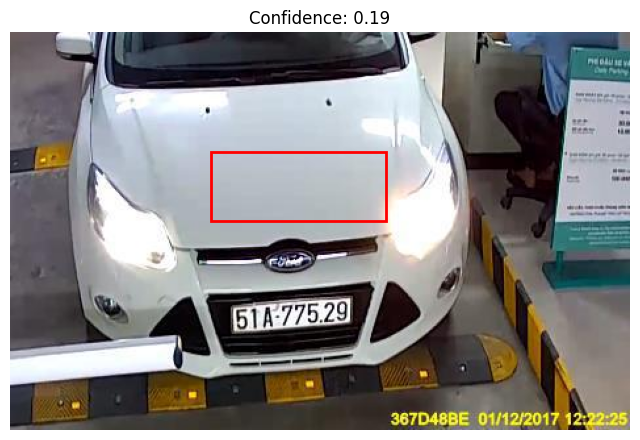

In [55]:
sample = random.choice(ds["test"])
image, box, conf = infer_single_image(model, sample)
show_prediction(image, box, conf)